In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
from src.mplstyle import set as set_mplstyle
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess

set_mplstyle("Fira Sans")

RESULTS_PATH = Path("./output/scaling_analysis/")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

DATA_DOC_PATH = Path("./data/dataset_docs/")
STATION_LIST = pd.read_csv(DATA_DOC_PATH / "pt_stations_ge30y_80pct_good.csv")

COLORS = ["#0C5DA5", "#FF2C00", "#FF9500", "#474747", "#9e9e9e"]
MARKERS = ["o", "s", "^", "*", "+"]

In [2]:
STATION_LIST

,StnID,Lat,Lon,Elev,State/Province,Name,UTC_Offset,POR_Date_Range_P,PCT_POR_Good_P,Num_Years_P,POR_Date_Range_T,Num_Years_T,PCT_POR_Good_T,overlap_years,PCT_Good_Overlap_1h,PCT_Good_Overlap_24h,Clim_Reg,KG
0,USC00410569,28.9798,-95.9749,15.8,TX,BAY CITY WATERWORKS,-6,19400601-20240417,57.1,84,19091001-20240331,116.0,70.2,85,87.1,89.5,S,14
1,USC00241737,47.8205,-112.1921,1172.0,MT,CHOTEAU,-7,19400101-20240401,93.8,84,18930101-20240504,132.0,83.6,85,96.2,98.1,NRP,7
2,USW00093914,31.7831,-95.6039,141.7,TX,PALESTINE 2 NE,-6,19400201-20240213,86.7,84,19300101-20240324,95.0,92.2,85,91.7,89.2,S,14
3,USC00414670,30.4452,-99.8044,532.5,TX,JUNCTION 4SSW,-6,19400301-20240401,90.4,84,18970127-20240503,128.0,75.0,85,84.5,88.7,S,6
4,USC00319476,35.6939,-77.9461,33.5,NC,WILSON 3 SW,-5,19400801-20240415,82.6,84,19161001-20240502,109.0,81.6,85,97.7,98.8,SE,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,USC00170100,44.3738,-68.2591,143.3,ME,ACADIA NATIONAL PARK,-5,19820907-20120704,86.8,30,19820901-20140531,33.0,94.8,31,94.8,94.4,NE,26
709,USC00478316,42.9676,-88.5495,283.2,WI,SULLIVAN 3 SE - WFO MKX,-6,19940901-20240402,85.6,30,19950101-20240504,30.0,96.8,30,98.2,97.7,UM,25
710,USC00084095,25.5011,-80.5500,2.7,FL,HOMESTEAD GEN AVIATION AP,-5,19950701-20240402,84.0,29,19900601-20240504,35.0,88.2,30,95.3,94.5,SE,3
711,USC00033544,36.0700,-93.7522,543.5,AR,HUNTSVILLE 1 SSW,-6,19830501-20120925,90.1,29,19830501-20120924,30.0,97.2,30,97.0,97.7,S,14


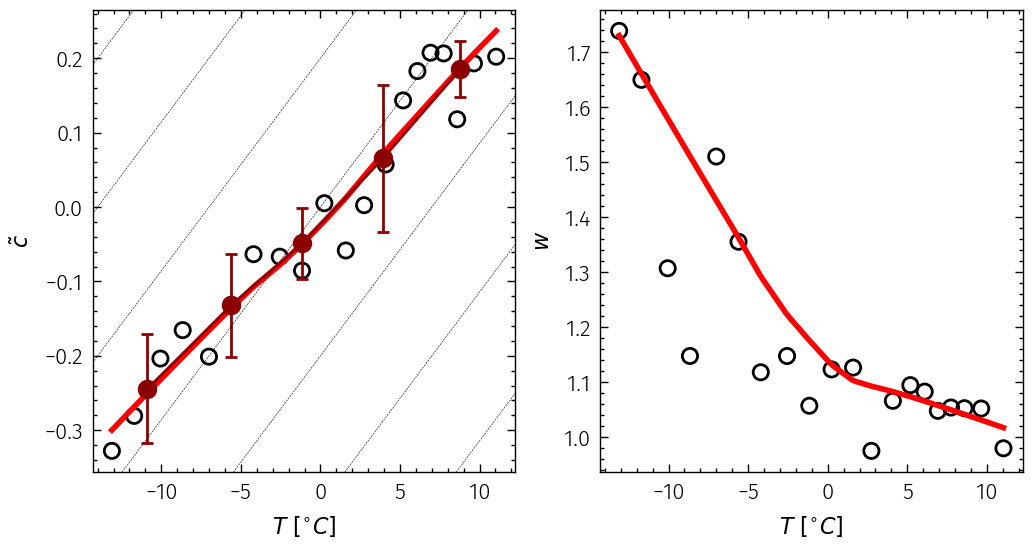

In [ ]:
stn_id = "USC00114198"
d = "1h"
var = "TMEAN"
cw_scaling, normalization = load_pt_scaling_results(stn_id, d, var)


cw_scaling = normalize_results(cw_scaling, normalization, var=var)
if var == "TMEAN":
    cw_scaling['c'] = np.log10(cw_scaling['c'])

T_interp = np.linspace(cw_scaling[f"{var}_med"].min(), cw_scaling[f"{var}_med"].max(), 100)

c_interpolated = lowess_and_interp(cw_scaling[f"{var}_med"].values, cw_scaling["c"].values, T_interp, frac=0.7)
w_interpolated = lowess_and_interp(cw_scaling[f"{var}_med"].values, cw_scaling["w"].values, T_interp, frac=0.7)

c_bin = bin_and_analyze(cw_scaling, n_bins=5, x_col='TMEAN_med', y_col='c')

fig, axs = plt.subplots(1, 2, figsize=(6,3))

axs[0].scatter(cw_scaling[f"{var}_med"], cw_scaling["c"], s=30, ec='k', fc='none')
axs[0].plot(T_interp, c_interpolated, "-r", lw=2)

# axs[0].plot(c_bin["x_mean"], c_bin["c_mean"], '-o', lw=2, c="darkred")
# axs[0].fill_between(c_bin["x_mean"], 
#                     c_bin["c_mean"] - c_bin["c_std"], 
#                     c_bin["c_mean"] + c_bin["c_std"], 
#                     alpha=0.3, color="darkred")
axs[0].errorbar(c_bin["x_mean"], c_bin["c_mean"], yerr=c_bin["c_std"], fmt='-o', lw=1, c="darkred", capsize=2)

axs[1].plot(T_interp, w_interpolated, "-r", lw=2)
axs[1].scatter(cw_scaling[f"{var}_med"], cw_scaling["w"], s=30, ec='k', fc='none')

plot_cc_reference_line(axs[0])
axs[0].set(xlabel="$T~[^{\circ} C]$", ylabel="$\\tilde{c}$")
axs[1].set(xlabel="$T~[^{\circ} C]$", ylabel="$w$")
plt.show()

In [3]:
kg_descriptions = {
            1: 'Af',
            2: 'Am',
            3: 'Aw',
            4: 'BWh',
            5: 'BWk',
            6: 'BSh',
            7: 'BSk',
            8: 'Csa',
            9: 'Csb',
            10: 'Csc',
            11: 'Cwa',
            12: 'Cwb',
            13: 'Cwc',
            14: 'Cfa',
            15: 'Cfb',
            16: 'Cfc',
            17: 'Dsa',
            18: 'Dsb',
            19: 'Dsc',
            20: 'Dsd',
            21: 'Dwa',
            22: 'Dwb',
            23: 'Dwc',
            24: 'Dwd',
            25: 'Dfa',
            26: 'Dfb',
            27: 'Dfc',
            28: 'Dfd',
            29: 'ET',
            30: 'EF'
        }

def load_pt_scaling_results(stn_id, duration, var):
    """ 
    Load the scaling analysis results with TMEAN as exogenous variable for a single duration
    """
    cw_scaling = pd.read_csv(RESULTS_PATH / duration / var / f"cw_scaling_{stn_id}.csv")
    with open(RESULTS_PATH / duration / var / f"cw_normalization_{stn_id}.json", 'r') as f:
        normalization = json.load(f)
    return cw_scaling, normalization

def plot_cc_reference_line(ax, T=None, super_cc=False):
    if T is None:
        T = np.linspace(-5, 35, 20)
    for c0 in [1e-2, 1e-1, 1, 1e1, 1e2]:
        # Standard CC scaling
        ax.plot(T, (c0 * (0.068 + 1) ** T), "--k", linewidth=0.2)
        if super_cc:
            # Super-CC scaling
            ax.plot(
                T, (c0 * (2 * 0.068 + 1) ** T), "--", alpha=0.8, linewidth=0.2, c="r"
            )

def lowess_and_interp(x, y, x_interp, frac=0.5):
    x_interp = np.asarray(x_interp)

    loess_result = lowess(y, x, frac=frac, return_sorted=True)
    x_loess, y_loess = loess_result[:, 0], loess_result[:, 1]

    loess_interp = interp1d(x_loess, y_loess, kind="linear", fill_value="extrapolate")
    return loess_interp(x_interp)

def bin_and_analyze(df, n_bins=10, x_col='TMEAN_med', y_col='c'):
    """
    Bin pooled data into equal-sized bins and compute bin statistics
    """
    df = df.copy()
    df['bin'] = pd.cut(df[x_col], bins=n_bins, labels=False)
    
    bin_stats = df.groupby('bin').agg({
        x_col: ['mean', 'count'],
        y_col: ['mean', 'std']
    }).round(4)
    

    bin_stats.columns = ['x_mean', 'count', y_col+'_mean', y_col+'_std']
    bin_stats = bin_stats.reset_index()
    bin_stats = bin_stats.dropna()
    return bin_stats

def normalize_results(cw_scaling_, normalization, var, center_temp=True):
    cw_scaling = cw_scaling_.copy()
    cw_scaling["c"] = cw_scaling["c"] / normalization["c0"]
    cw_scaling["w"] = cw_scaling["w"] / normalization["w0"]
    if var == "TMEAN" and center_temp:
        cw_scaling[f"{var}_med"] = cw_scaling[f"{var}_med"] - normalization["Tmean"]

    return cw_scaling

def plot_scaling(d, var, xlabel, center_temp=False):
    # Configuration
    ylabels = ["$log~\\tilde{c}$" if var == "TMEAN" else "$\\tilde{c}$", "$w$"]
    groups = [[14, 25, 7], [26, 5, 9]]
    params = ["c", "w"]
    
    fig, axs = plt.subplots(2, 2, figsize=(5, 4), tight_layout=True)
    
    # Process data and collect limits
    xlim, ylim = {param: [] for param in params}, {param: [] for param in params}
    
    for i, group in enumerate(groups):
        plot_group_data(axs, group, i, d, var, center_temp)
        collect_axis_limits(axs, xlim, ylim, i)
    
    # Set axis properties
    setup_axes(axs, xlim, ylim, ylabels, xlabel, var)
    
    plt.show()


def plot_group_data(axs, group, col_idx, d, var, center_temp):
    """Plot data for a single group of regions."""
    for j, region in enumerate(group):
        stations = STATION_LIST[STATION_LIST["KG"] == region]["StnID"].values
        pooled_cw = process_stations(stations, d, var, center_temp)
        
        plot_parameters(axs, pooled_cw, col_idx, j, region, var)


def process_stations(stations, d, var, center_temp):
    """Process all stations and return pooled results."""
    pool = []
    for stn_id in stations:
        cw_scaling, normalization = load_pt_scaling_results(stn_id, d, var)
        cw_scaling = normalize_results(cw_scaling, normalization, var=var, center_temp=center_temp)
        
        if var == "TMEAN":
            cw_scaling['c'] = np.log10(cw_scaling['c'])
        
        pool.append(cw_scaling)
    
    return pd.concat(pool)


def plot_parameters(axs, pooled_cw, col_idx, region_idx, region, var):
    """Plot both parameters (c and w) for the given data."""
    for param_idx, param in enumerate(["c", "w"]):
        res = bin_and_analyze(pooled_cw, n_bins=20, x_col=var+'_med', y_col=param)
        
        ax = axs[param_idx, col_idx]
        color = COLORS[region_idx]
        
        # Mean scaling
        ax.plot(res["x_mean"], res[f"{param}_mean"], '-', 
                lw=2, c=color, label=kg_descriptions[region])
        
        # Error band (std)
        ax.fill_between(res["x_mean"],
                       res[f"{param}_mean"] - res[f"{param}_std"],
                       res[f"{param}_mean"] + res[f"{param}_std"],
                       alpha=0.3, color=color)


def collect_axis_limits(axs, xlim, ylim, col_idx):
    """Collect axis limits for later synchronization."""
    xlim["c"].append(axs[0, col_idx].get_xlim())
    xlim["w"].append(axs[1, col_idx].get_xlim())
    ylim["c"].append(axs[0, col_idx].get_ylim())
    ylim["w"].append(axs[1, col_idx].get_ylim())


def setup_axes(axs, xlim, ylim, ylabels, xlabel, var):
    """Configure axis properties, labels, and limits."""
    # Convert to arrays for easier manipulation
    for param in ["c", "w"]:
        xlim[param] = np.asarray(xlim[param])
        ylim[param] = np.asarray(ylim[param])
    
    for i in range(2):  # rows
        for j in range(2):  # columns
            ax = axs[i, j]
            
            # Top row (c parameter)
            if i == 0:
                add_cc_scaling_lines(ax, xlim, ylim, var)
                ax.set_xlim(xlim["c"][:, 0].min(), xlim["c"][:, 1].max())
                ax.set_ylim(ylim["c"][:, 0].min(), ylim["c"][:, 1].max())
            
            # Bottom row (w parameter)
            if i == 1:
                ax.legend()
                ax.set_xlabel(xlabel)
                ax.set_xlim(xlim["w"][:, 0].min(), xlim["w"][:, 1].max())
                ax.set_ylim(ylim["w"][:, 0].min(), ylim["w"][:, 1].max())
            
            # Left column
            if j == 0:
                ax.set_ylabel(ylabels[i])


def add_cc_scaling_lines(ax, xlim, ylim, var):
    """Add CC-scaling reference lines for temperature data."""
    if var == "TMEAN":
        for c0 in np.linspace(ylim["c"][:, 0].min(), ylim["c"][:, 1].max(), 3):
            T = np.linspace(xlim["c"][:, 0].min(), xlim["c"][:, 1].max(), 10)
            y_line = c0 + np.log10(0.068 + 1) * (T - np.mean(T))
            ax.plot(T, y_line, "--k", linewidth=0.2)

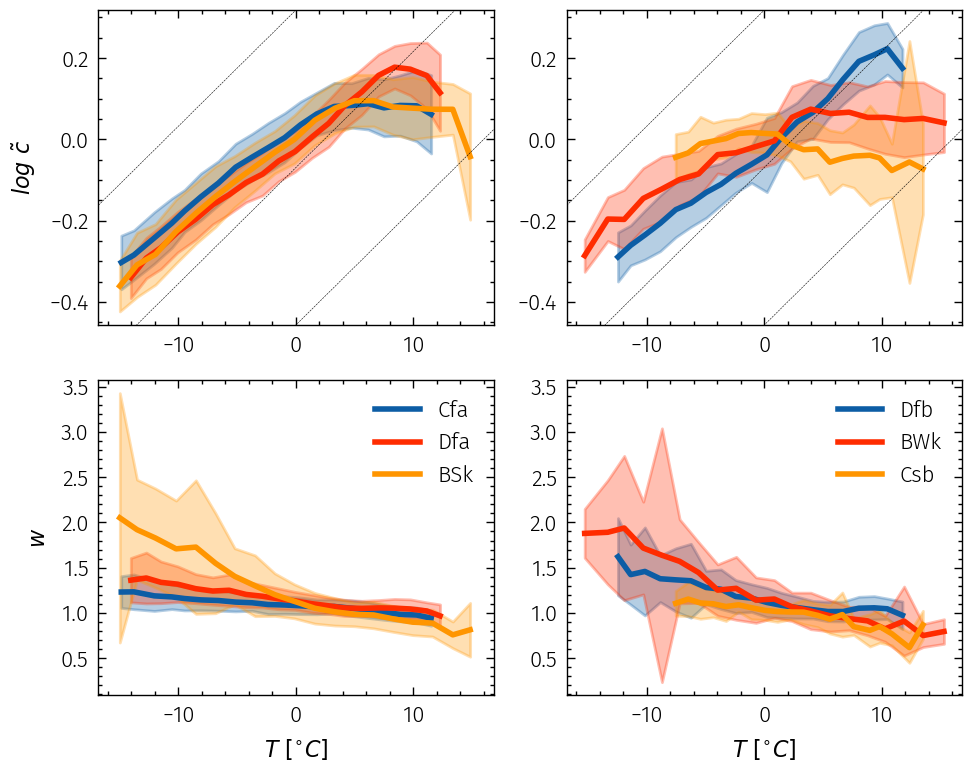

In [4]:
d = "1h"
var = "TMEAN"
xlabel = "$T~[^{\circ} C]$"

plot_scaling(d, var, xlabel, center_temp=True)

In [ ]:
ylabels = ["$\\tilde{c}$", "$w$"]
groups = [["SE", "NE", "OV"], ["NW", "NRP", "UM"], ["W", "SW", "S"]]

d = "1h"
var = "TMEAN"

fig, axs = plt.subplots(2,3, figsize=(9, 5), tight_layout=True)

xlim = {"c": [], "w": []}
ylim = {"c": [], "w": []}

for i, group in enumerate(groups):
    for j, region in enumerate(group):
        stations = STATION_LIST[STATION_LIST["Clim_Reg"] == region]["StnID"].values

        # Compute interpolation range
        Tminmax = [] 
        for stn_id in stations:
            cw_scaling, normalization = load_pt_scaling_results(stn_id, d, var)
            cw_scaling = normalize_results(cw_scaling, normalization, var=var)
            Tminmax.append((cw_scaling[f"{var}_med"].min(), cw_scaling[f"{var}_med"].max()))
        Tminmax = np.array(Tminmax)
        T_interp = np.linspace(Tminmax[:, 0].max(), Tminmax[:, 1].min(), 100)

        # Compute ensemble
        ens = {'c': np.zeros((len(stations), 100)), 'w': np.zeros((len(stations), 100))}

        pool = []
        for k, stn_id in enumerate(stations):
            cw_scaling, normalization = load_pt_scaling_results(stn_id, d, var)
            cw_scaling = normalize_results(cw_scaling, normalization, var=var)
            if var == "TMEAN":
                cw_scaling['c'] = np.log10(cw_scaling['c'])
            pool.append(cw_scaling)

        pooled_cw = pd.concat(pool)
        for l, param in enumerate(["c", "w"]):
            res = bin_and_analyze(pooled_cw, n_bins=20, x_col=var+'_med', y_col=param)
            axs[l,i].plot(res["x_mean"], res[param+"_mean"], '-o', lw=2, c=COLORS[j])
            axs[l,i].fill_between(res["x_mean"], 
                                res[param+"_mean"] - res[param+"_std"], 
                                res[param+"_mean"] + res[param+"_std"], 
                                alpha=0.3, color=COLORS[j])
            
#     xlim["c"].append(axs[0, i].get_xlim())
#     xlim["w"].append(axs[1, i].get_xlim())
#     ylim["c"].append(axs[0, i].get_ylim())
#     ylim["w"].append(axs[1, i].get_ylim())

# for l, param in enumerate(["c", "w"]):
#     xlim[param] = np.asarray(xlim[param])
#     ylim[param] = np.asarray(ylim[param])

    plot_cc_reference_line(axs[0, i])

for i in range(2):
    for j in range(3):
        if i == 0:
            axs[i,j].legend()
            # axs[i, j].set_xlim((xlim["c"][:, 0].min(), xlim["c"][:, 1].max()))
            # axs[i, j].set_ylim((ylim["c"][:, 0].min(), ylim["c"][:, 1].max()))
        if i == 1:
            axs[i,j].set_xlabel("$T~[^{\circ} C]$")
            # axs[i, j].set_xlim((xlim["w"][:, 0].min(), xlim["w"][:, 1].max()))
            # axs[i, j].set_ylim((ylim["w"][:, 0].min(), ylim["w"][:, 1].max()))
        if j == 0:
            axs[i,j].set_ylabel(ylabels[i])
plt.show()


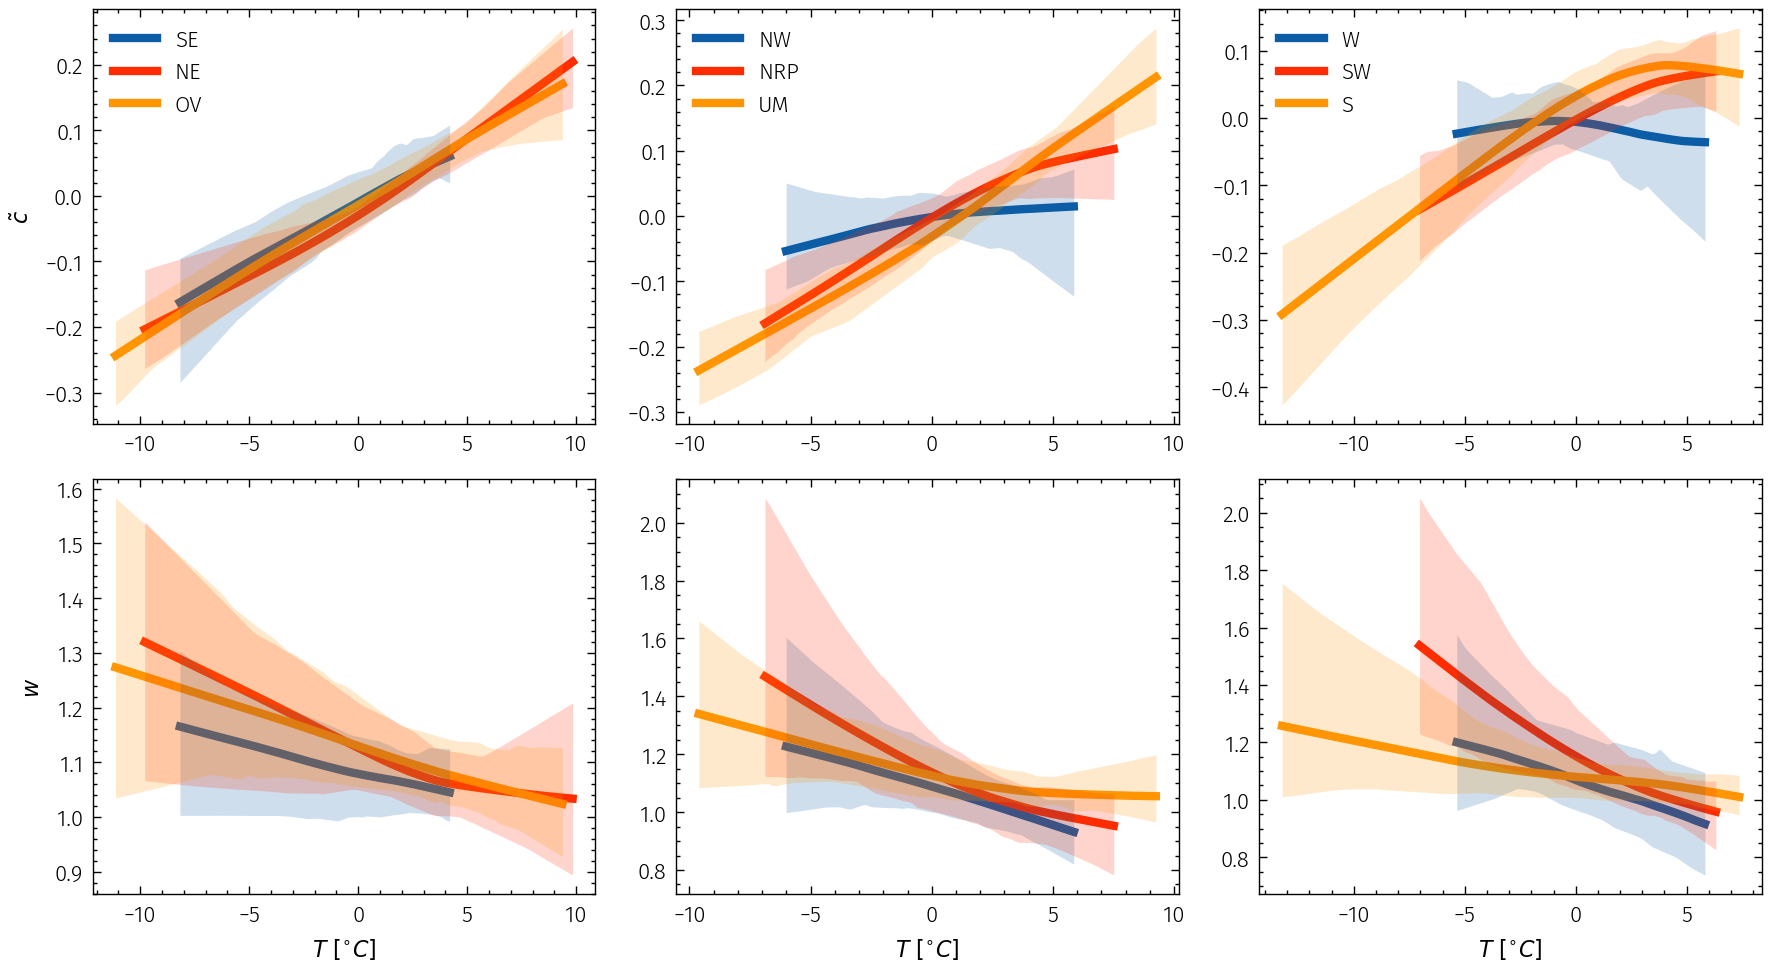

In [22]:
ylabels = ["$\\tilde{c}$", "$w$"]
groups = [["SE", "NE", "OV"], ["NW", "NRP", "UM"], ["W", "SW", "S"]]

d = "1h"
var = "TMEAN"

fig, axs = plt.subplots(2,3, figsize=(9, 5), tight_layout=True)

for i, group in enumerate(groups):
    for j, region in enumerate(group):
        stations = STATION_LIST[STATION_LIST["Clim_Reg"] == region]["StnID"].values

        # Compute interpolation range
        Tminmax = [] 
        for stn_id in stations:
            cw_scaling, normalization = load_pt_scaling_results(stn_id, d, var)
            cw_scaling = normalize_results(cw_scaling, normalization, var=var)
            Tminmax.append((cw_scaling[f"{var}_med"].min(), cw_scaling[f"{var}_med"].max()))
        Tminmax = np.array(Tminmax)
        T_interp = np.linspace(Tminmax[:, 0].max(), Tminmax[:, 1].min(), 100)

        # Compute ensemble
        ens = {'c': np.zeros((len(stations), 100)), 'w': np.zeros((len(stations), 100))}
        for k, stn_id in enumerate(stations):
            cw_scaling, normalization = load_pt_scaling_results(stn_id, d, var)
            cw_scaling = normalize_results(cw_scaling, normalization, var=var)
            if var == "TMEAN":
                cw_scaling['c'] = np.log10(cw_scaling['c'])

            ens["c"][k] = lowess_and_interp(cw_scaling[f"{var}_med"].values, cw_scaling["c"].values, T_interp, frac=0.7)
            ens["w"][k] = lowess_and_interp(cw_scaling[f"{var}_med"].values, cw_scaling["w"].values, T_interp, frac=0.7)

        res = {}
        for key in ["c", "w"]:
            ensemble_mean = np.nanmean(ens[key], axis=0)
            ci_lower = np.nanpercentile(ens[key], 2.5, axis=0)
            ci_upper = np.nanpercentile(ens[key], 97.5, axis=0)
        
            res[key] = {
                'mean': ensemble_mean,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
            }
        
        axs[0, i].plot(T_interp, res["c"]['mean'], "-", linewidth=3, c=COLORS[j], label=region, zorder=1)
        axs[1, i].plot(T_interp, res["w"]['mean'], "-", linewidth=3, c=COLORS[j], zorder=1)


        axs[0, i].fill_between(
                    T_interp, 
                    res["c"]['ci_lower'], 
                    res["c"]['ci_upper'],
                    color=COLORS[j], 
                    alpha=0.2,
                    lw=0,
                    zorder=2
                )
        axs[1, i].fill_between(
                    T_interp, 
                    res["w"]['ci_lower'], 
                    res["w"]['ci_upper'],
                    color=COLORS[j], 
                    alpha=0.2,
                    lw=0,
                    zorder=2
                )
        
    #plot_cc_reference_line(axs[0, i])

for i in range(2):
    for j in range(3):
        if i == 0:
            axs[i,j].legend()
        if i == 1:
            axs[i,j].set_xlabel("$T~[^{\circ} C]$")
        if j == 0:
            axs[i,j].set_ylabel(ylabels[i])
plt.show()


# Large Scale

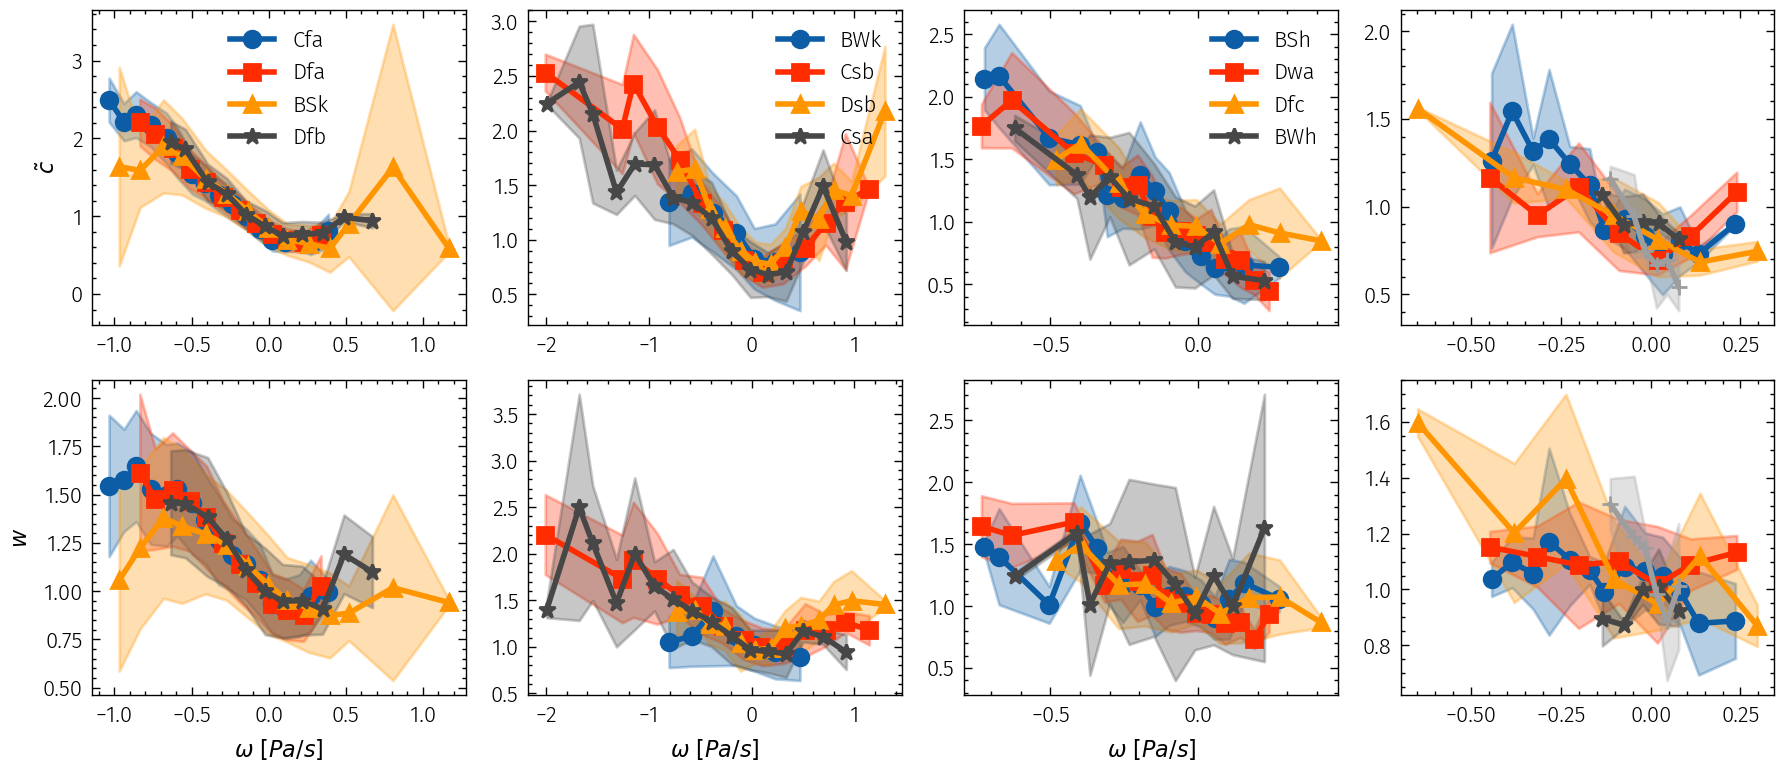

In [53]:
ylabels = ["$\\tilde{c}$", "$w$"]
groups = [[14,25,7,26],[5,9,18,8],[6,21,27,4],[22,19,15,17,3]]

d = "24h"
var = "W500"

fig, axs = plt.subplots(2,4, figsize=(9, 4), tight_layout=True)

xlim = {"c": [], "w": []}
ylim = {"c": [], "w": []}

for i, group in enumerate(groups):
    for j, region in enumerate(group):
        stations = STATION_LIST[STATION_LIST["KG"] == region]["StnID"].values

        # Compute interpolation range
        Tminmax = [] 
        for stn_id in stations:
            cw_scaling, normalization = load_pt_scaling_results(stn_id, d, var)
            cw_scaling = normalize_results(cw_scaling, normalization, var=var)
            Tminmax.append((cw_scaling[f"{var}_med"].min(), cw_scaling[f"{var}_med"].max()))
        Tminmax = np.array(Tminmax)
        T_interp = np.linspace(Tminmax[:, 0].max(), Tminmax[:, 1].min(), 100)

        # Compute ensemble
        ens = {'c': np.zeros((len(stations), 100)), 'w': np.zeros((len(stations), 100))}

        pool = []
        for k, stn_id in enumerate(stations):
            cw_scaling, normalization = load_pt_scaling_results(stn_id, d, var)
            cw_scaling = normalize_results(cw_scaling, normalization, var=var)
            if var == "TMEAN":
                cw_scaling['c'] = np.log10(cw_scaling['c'])
            pool.append(cw_scaling)

        pooled_cw = pd.concat(pool)
        for l, param in enumerate(["c", "w"]):
            res = bin_and_analyze(pooled_cw, n_bins=20, x_col=var+'_med', y_col=param)
            axs[l,i].plot(res["x_mean"], res[param+"_mean"], '-', lw=2, c=COLORS[j], label=kg_descriptions[region], marker=MARKERS[j])
            axs[l,i].fill_between(res["x_mean"], 
                                res[param+"_mean"] - res[param+"_std"], 
                                res[param+"_mean"] + res[param+"_std"], 
                                alpha=0.3, color=COLORS[j])

for i in range(2):
    for j in range(3):
        if i == 0:
            axs[i,j].legend()
        if i == 1:
            axs[i,j].set_xlabel("$\omega~[Pa/s]$")
        if j == 0:
            axs[i,j].set_ylabel(ylabels[i])
plt.show()
